In [1]:
import pandas as pd

In [2]:
# load datasets
train_df = pd.read_csv("credit_train.csv")
test_df = pd.read_csv("credit_test.csv")

In [3]:
# Display basic info and class distribution
train_df.info(), train_df["Loan Status"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinquent  46859 non-null

(None,
 Loan Status
 Fully Paid     77361
 Charged Off    22639
 Name: count, dtype: int64)

In [4]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# 2. Load Dataset
df = pd.read_csv("credit_train.csv")

In [6]:
# 3. Basic EDA
print("\n📌 Data Overview:")
print(df.info())
print("\n🔍 Missing Values:")
print(df.isnull().sum().sort_values(ascending=False))
print("\n🎯 Target Distribution:")
print(df["Loan Status"].value_counts())


📌 Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan ID                       100000 non-null  object 
 1   Customer ID                   100000 non-null  object 
 2   Loan Status                   100000 non-null  object 
 3   Current Loan Amount           100000 non-null  float64
 4   Term                          100000 non-null  object 
 5   Credit Score                  80846 non-null   float64
 6   Annual Income                 80846 non-null   float64
 7   Years in current job          95778 non-null   object 
 8   Home Ownership                100000 non-null  object 
 9   Purpose                       100000 non-null  object 
 10  Monthly Debt                  100000 non-null  float64
 11  Years of Credit History       100000 non-null  float64
 12  Months since last delinque

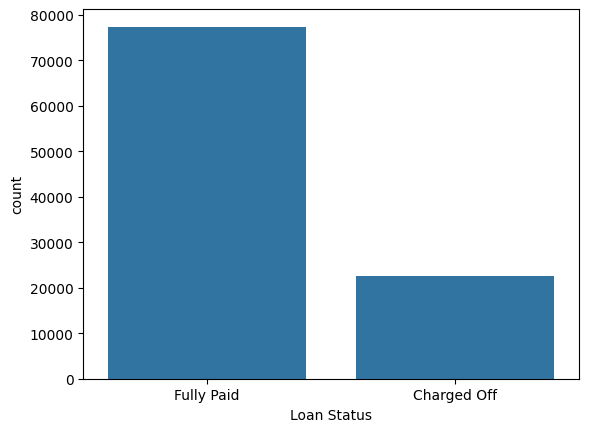

In [7]:
#VISUALIZATION
sns.countplot(x='Loan Status', data=df)
plt.show()

In [8]:
# 4. Target Encoding
df["Loan Status"] = df["Loan Status"].map({"Fully Paid": 0, "Charged Off": 1})

In [9]:
# ⚠️ Drop rows where target is NaN
df = df.dropna(subset=["Loan Status"])

In [10]:
# 5. Feature Engineering
df["dti"] = df["Monthly Debt"] / (df["Annual Income"] + 1)
df["loan_to_income"] = df["Current Loan Amount"] / (df["Annual Income"] + 1)
df["loan_term_months"] = df["Term"].map({"Short Term": 36, "Long Term": 60})
df["monthly_installment_est"] = df["Current Loan Amount"] / (df["loan_term_months"] + 1)

In [11]:
def score_bucket(score):
    if pd.isna(score):
        return "Unknown"
    elif score >= 750:
        return "Excellent"
    elif score >= 700:
        return "Good"
    elif score >= 650:
        return "Fair"
    else:
        return "Poor"
df["credit_score_bucket"] = df["Credit Score"].apply(score_bucket)

In [12]:
def parse_years(val):
    if pd.isna(val):
        return np.nan
    if val == "10+ years":
        return 10
    if val == "< 1 year":
        return 0.5
    return float(val.split()[0])

df["years_in_job_num"] = df["Years in current job"].apply(parse_years)

In [13]:
#Creates binary features indicating missing values
# Missing value flags
df["Credit_Score_missing"] = df["Credit Score"].isnull().astype(int)
df["Annual_Income_missing"] = df["Annual Income"].isnull().astype(int)
df["Delinquent_missing"] = df["Months since last delinquent"].isnull().astype(int)

In [14]:
# Drop unused columns
drop_cols = ['Loan ID', 'Customer ID', 'Years in current job', 'Term']
df.drop(columns=drop_cols, inplace=True)

In [15]:
# 6. Handle Missing Values
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_cols.remove("Loan Status")
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [16]:
# 7. Encode Categorical Columns
cat_cols = df.select_dtypes(include="object").columns.tolist()
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

In [17]:
# 8. Scale Numerical Features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [18]:
# 9. Split Data
X = df.drop("Loan Status", axis=1)
y = df["Loan Status"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
# 10. Train and Evaluate Models
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    print(f"\n🔍 {name} Evaluation")
    print(confusion_matrix(y_val, preds))
    print(classification_report(y_val, preds))
    print(f"✅ Accuracy: {accuracy_score(y_val, preds):.4f}")

In [20]:
# Logistic Regression
evaluate_model(LogisticRegression(max_iter=1000), "Logistic Regression")


🔍 Logistic Regression Evaluation
[[15472     0]
 [ 3594   934]]
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90     15472
         1.0       1.00      0.21      0.34      4528

    accuracy                           0.82     20000
   macro avg       0.91      0.60      0.62     20000
weighted avg       0.85      0.82      0.77     20000

✅ Accuracy: 0.8203


In [21]:
# Random Forest
evaluate_model(RandomForestClassifier(n_estimators=100, class_weight="balanced"), "Random Forest")


🔍 Random Forest Evaluation
[[15333   139]
 [ 3482  1046]]
              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89     15472
         1.0       0.88      0.23      0.37      4528

    accuracy                           0.82     20000
   macro avg       0.85      0.61      0.63     20000
weighted avg       0.83      0.82      0.77     20000

✅ Accuracy: 0.8189


In [22]:
# K-Nearest Neighbors
evaluate_model(KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors")


🔍 K-Nearest Neighbors Evaluation
[[14509   963]
 [ 3153  1375]]
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88     15472
         1.0       0.59      0.30      0.40      4528

    accuracy                           0.79     20000
   macro avg       0.70      0.62      0.64     20000
weighted avg       0.77      0.79      0.77     20000

✅ Accuracy: 0.7942
